In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

# %pip install -q ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
style = {'description_width': 'initial'}

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [76]:
df = pd.read_csv(r'C:\Users\yahya\Documents\GitHub\Internship\CSV_files\diag_final_pulmonary.csv')

In [77]:
df = df.drop(columns=['cml_date', 'cvd_date'], axis=1)

In [78]:
df = df.drop(columns= ['Unnamed: 0'], axis = 1)

In [79]:
df = df.drop_duplicates()
df

,subject_id,doses_per_24_hrs,duration_med,prescribed_dose,Cabozantinib,Crizotinib,Dasatinib,Imatinib,Nilotinib,Ruxolitinib,pulmonary,has_future_pulmonary,has_immediate_pulmonary,has_pulmonary,has_pulmonary_before_cml,duration_cvd,valuenum,atypical lymphocytes,metamyelocytes,blasts,alanine aminotransferase (alt),albumin,basophils,"bilirubin, total",eosinophils,glucose,lactate dehydrogenase (ld),monocytes,platelet count,red blood cells,urea nitrogen,promyelocytes,"cholesterol, total",c-reactive protein,ntprobnp,% hemoglobin a1c,mean_bmi,mean_systolic,mean_diastolic
0,10010231,1.590909,9.090909,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,1.0,1.083333,2.904762,21.000000,55.454545,3.796667,0.372727,0.464706,0.493333,127.666667,197.123288,20.188333,122.783133,2.558810,11.325581,NaN,NaN,NaN,NaN,NaN,31.835000,131.184211,80.263158
1,10026643,1.785714,37.750000,20.000000,0,0,0,0,0,1,NaN,0,0,0,0,NaN,3.0,2.500000,6.555556,3.833333,10.375000,3.662500,1.500000,0.340000,0.800000,105.866667,1008.300000,3.750000,330.615385,3.335000,17.000000,2.750000,NaN,NaN,NaN,NaN,39.000000,125.238095,68.857143
2,10035631,1.613636,12.619048,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,1.0,1.650000,3.416667,27.447368,52.398058,3.328125,0.728000,0.828000,5.640385,139.333333,1534.135338,11.592308,138.093750,2.908594,35.261364,4.555556,99.0,139.300,NaN,NaN,24.939130,112.145833,64.989583
3,10070928,1.851064,23.464286,NaN,0,0,0,0,0,0,1.0,1,0,1,0,16.590013,0.0,2.847826,0.965517,4.060606,52.903226,2.969565,0.260870,0.375000,2.530612,103.935484,172.360000,24.696429,59.787879,2.816154,29.144737,2.500000,NaN,125.275,772.000000,NaN,NaN,118.700000,55.150000
4,10083304,1.333333,1.000000,400.000000,0,0,0,1,0,0,NaN,0,0,0,0,NaN,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.400000,NaN,NaN,351.625000,5.211429,11.571429,NaN,126.0,NaN,NaN,7.00,33.788889,141.350000,67.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,19923916,1.782609,8.642857,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,0.0,3.142857,0.909091,24.192500,50.830769,2.954167,2.625000,1.564286,2.656250,106.337662,597.790698,14.661364,20.983333,2.950482,32.307692,1.250000,NaN,NaN,2320.000000,NaN,23.760000,131.400000,60.200000
853,19940147,1.682540,9.531250,283.333333,0,0,0,0,6,0,NaN,0,0,0,0,NaN,0.0,2.108108,4.505618,21.045455,75.728324,3.019565,11.374138,0.975294,4.385333,125.929461,364.674107,8.889362,85.599251,2.887252,36.115854,1.500000,223.8,9.300,31804.333333,5.60,24.407921,131.313043,75.704348
854,19944328,1.735294,8.125000,NaN,0,0,0,0,0,0,1.0,1,0,1,0,1.511170,2.0,1.727273,1.842105,40.707692,43.858491,3.324138,1.246154,1.205882,7.804545,200.361290,499.426752,11.617568,61.485714,2.750676,22.945055,1.400000,85.0,NaN,NaN,9.05,27.200000,146.404762,70.761905
855,19997367,2.052632,27.333333,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,0.0,0.000000,0.000000,NaN,21.540541,3.766667,0.220000,1.942105,1.584615,128.238806,305.136364,5.316667,120.150000,3.570476,37.000000,NaN,NaN,NaN,3945.400000,6.70,25.393878,101.169643,54.589286


In [80]:
patient_info = pd.read_csv(r'C:\Users\yahya\Documents\GitHub\Internship\CSV_files\patients_info_table.csv')
patient_info

,subject_id,icd_code,gender,anchor_age,result_name,result_value
0,10246275,E9308,F,37,Weight,215.9
1,10246275,E9308,F,37,Weight,215.0
2,10303503,49390,F,23,Weight,166.0
3,10303503,34690,F,23,Weight,166.0
4,11084812,7856,F,28,Weight,520.0
...,...,...,...,...,...,...
593620,19401821,B9620,F,91,Weight,99.00
593621,19683913,Z6821,F,91,Weight,104.70
593622,19728698,K5900,M,91,Weight,127.20
593623,19728698,Z9981,M,91,Weight,127.20


In [81]:
df = df.merge(patient_info[['subject_id', 'gender', 'anchor_age']], on='subject_id')
df = df.reset_index(drop=True)
df

,subject_id,doses_per_24_hrs,duration_med,prescribed_dose,Cabozantinib,Crizotinib,Dasatinib,Imatinib,Nilotinib,Ruxolitinib,pulmonary,has_future_pulmonary,has_immediate_pulmonary,has_pulmonary,has_pulmonary_before_cml,duration_cvd,valuenum,atypical lymphocytes,metamyelocytes,blasts,alanine aminotransferase (alt),albumin,basophils,"bilirubin, total",eosinophils,glucose,lactate dehydrogenase (ld),monocytes,platelet count,red blood cells,urea nitrogen,promyelocytes,"cholesterol, total",c-reactive protein,ntprobnp,% hemoglobin a1c,mean_bmi,mean_systolic,mean_diastolic,gender,anchor_age
0,10083304,1.333333,1.0,400.0,0,0,0,1,0,0,NaN,0,0,0,0,NaN,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.400000,NaN,NaN,351.625000,5.211429,11.571429,NaN,126.0,NaN,NaN,7.0,33.788889,141.350000,67.300000,F,57
1,10083304,1.333333,1.0,400.0,0,0,0,1,0,0,NaN,0,0,0,0,NaN,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.400000,NaN,NaN,351.625000,5.211429,11.571429,NaN,126.0,NaN,NaN,7.0,33.788889,141.350000,67.300000,F,57
2,10083304,1.333333,1.0,400.0,0,0,0,1,0,0,NaN,0,0,0,0,NaN,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.400000,NaN,NaN,351.625000,5.211429,11.571429,NaN,126.0,NaN,NaN,7.0,33.788889,141.350000,67.300000,F,57
3,10083304,1.333333,1.0,400.0,0,0,0,1,0,0,NaN,0,0,0,0,NaN,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.400000,NaN,NaN,351.625000,5.211429,11.571429,NaN,126.0,NaN,NaN,7.0,33.788889,141.350000,67.300000,F,57
4,10083304,1.333333,1.0,400.0,0,0,0,1,0,0,NaN,0,0,0,0,NaN,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.400000,NaN,NaN,351.625000,5.211429,11.571429,NaN,126.0,NaN,NaN,7.0,33.788889,141.350000,67.300000,F,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29181,19912102,1.727273,2.5,400.0,0,0,0,1,0,0,NaN,0,0,0,0,NaN,5.0,1.0,1.5,4.285714,46.866667,4.033333,6.481818,0.275,3.028571,99.368421,454.947368,4.733333,909.413793,3.161538,18.050000,NaN,NaN,5.9,NaN,NaN,24.836585,124.278481,72.544304,F,57
29182,19912102,1.727273,2.5,400.0,0,0,0,1,0,0,NaN,0,0,0,0,NaN,5.0,1.0,1.5,4.285714,46.866667,4.033333,6.481818,0.275,3.028571,99.368421,454.947368,4.733333,909.413793,3.161538,18.050000,NaN,NaN,5.9,NaN,NaN,24.836585,124.278481,72.544304,F,57
29183,19912102,1.727273,2.5,400.0,0,0,0,1,0,0,NaN,0,0,0,0,NaN,5.0,1.0,1.5,4.285714,46.866667,4.033333,6.481818,0.275,3.028571,99.368421,454.947368,4.733333,909.413793,3.161538,18.050000,NaN,NaN,5.9,NaN,NaN,24.836585,124.278481,72.544304,F,57
29184,19912102,1.727273,2.5,400.0,0,0,0,1,0,0,NaN,0,0,0,0,NaN,5.0,1.0,1.5,4.285714,46.866667,4.033333,6.481818,0.275,3.028571,99.368421,454.947368,4.733333,909.413793,3.161538,18.050000,NaN,NaN,5.9,NaN,NaN,24.836585,124.278481,72.544304,F,57


In [83]:
df['gender'] = df['gender'].map({'M': 0, 'F': 1})


In [84]:
df = df.drop_duplicates(subset=['subject_id'])
df = df.reset_index(drop=True)
df

,subject_id,doses_per_24_hrs,duration_med,prescribed_dose,Cabozantinib,Crizotinib,Dasatinib,Imatinib,Nilotinib,Ruxolitinib,pulmonary,has_future_pulmonary,has_immediate_pulmonary,has_pulmonary,has_pulmonary_before_cml,duration_cvd,valuenum,atypical lymphocytes,metamyelocytes,blasts,alanine aminotransferase (alt),albumin,basophils,"bilirubin, total",eosinophils,glucose,lactate dehydrogenase (ld),monocytes,platelet count,red blood cells,urea nitrogen,promyelocytes,"cholesterol, total",c-reactive protein,ntprobnp,% hemoglobin a1c,mean_bmi,mean_systolic,mean_diastolic,gender,anchor_age
0,10083304,1.333333,1.000000,400.0,0,0,0,1,0,0,NaN,0,0,0,0,NaN,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.400000,NaN,NaN,351.625000,5.211429,11.571429,NaN,126.0,NaN,NaN,7.0,33.788889,141.350000,67.300000,1,57
1,10101615,1.806452,8.294118,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,2.0,1.888889,1.25,14.440000,34.406250,3.110526,1.094118,0.696875,2.136000,110.066667,201.758065,10.965079,126.302752,2.435728,14.596154,0.00,NaN,NaN,NaN,NaN,21.571429,105.883117,67.506494,1,78
2,10140662,1.416667,3.222222,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,3.0,1.000000,1.50,22.166667,35.333333,3.556250,0.827273,0.823529,0.840000,126.181818,408.137255,19.720833,134.549020,2.623061,19.192308,1.00,NaN,48.700000,1226.0,NaN,22.857143,117.840909,78.181818,1,57
3,10156269,1.760000,8.655172,250.0,0,0,1,1,0,0,1.0,1,0,1,0,65.407359,2.0,2.400000,3.00,3.400000,52.554455,3.637736,0.829268,0.435135,5.475000,117.024000,237.457627,10.420988,159.928571,2.992016,23.532609,4.75,283.0,138.700000,35348.0,6.2,21.569466,114.600000,66.787097,1,54
4,10188472,2.352941,1.666667,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,1.0,3.000000,5.50,13.750000,14.166667,2.975000,3.233333,0.600000,1.133333,143.411765,790.500000,21.175000,103.882353,2.962353,12.928571,1.00,NaN,NaN,NaN,NaN,38.796552,121.194805,65.311688,1,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,19415931,1.777778,17.076923,245.0,0,0,0,8,2,0,NaN,0,0,0,0,NaN,10.4,0.285714,5.50,2.000000,24.090909,3.486667,2.200000,0.638095,1.438095,101.286667,911.243902,8.100000,299.432624,2.870368,43.708955,4.00,191.0,60.387500,355.5,4.3,33.900000,143.393939,78.621212,0,56
152,19480766,1.250000,4.666667,400.0,0,0,0,1,0,0,NaN,0,0,0,0,NaN,0.5,NaN,5.25,1.000000,143.500000,3.500000,0.000000,0.500000,0.500000,101.900000,714.000000,5.000000,245.500000,3.710000,20.285714,NaN,NaN,160.033333,NaN,NaN,33.000000,134.500000,82.250000,0,57
153,19589672,1.600000,1.500000,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.000000,NaN,NaN,153.000000,4.180000,19.000000,NaN,NaN,NaN,NaN,NaN,35.384615,128.388889,75.666667,0,47
154,19777911,1.622642,20.189189,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,1.0,2.083333,2.25,6.500000,31.228571,3.461290,0.786364,0.842553,3.350000,117.446154,176.123077,12.348235,43.428571,2.803590,17.705882,1.00,165.0,NaN,3855.5,5.5,24.836000,127.763326,67.814499,1,61


In [85]:
df['Ruxolitinib'].value_counts()

0     140
2       3
4       3
1       3
12      2
9       2
48      1
18      1
6       1
Name: Ruxolitinib, dtype: int64

In [87]:
drug_cols = ['Cabozantinib', 'Crizotinib', 'Dasatinib', 'Imatinib', 'Nilotinib', 'Ruxolitinib']

def list_drugs(row):
    taken = [drug for drug in drug_cols if row[drug] >= 1]
    if not taken:
        return 'No_treatment'
    return ', '.join(taken)

df['drug'] = df.apply(list_drugs, axis=1)

In [88]:
df['drug'].value_counts()

No_treatment              120
Ruxolitinib                15
Imatinib                    9
Dasatinib                   6
Dasatinib, Nilotinib        2
Dasatinib, Imatinib         1
Dasatinib, Ruxolitinib      1
Nilotinib                   1
Imatinib, Nilotinib         1
Name: drug, dtype: int64

In [89]:
# Patients with no drug prescribed
no_treatment_patients = df.loc[df[drug_cols].sum(axis=1) == 0, 'subject_id']

no_treatment_df = df.loc[df['subject_id'].isin(no_treatment_patients)].copy()
no_treatment_df['drug'] = 'No_treatment'

# Combine
df_drugs_grouped = pd.concat([df, no_treatment_df], ignore_index=True)

In [90]:
print("Total unique patients:", df_drugs_grouped['subject_id'].nunique())
print("Drugs represented:", df_drugs_grouped['drug'].unique())

Total unique patients: 156
Drugs represented: ['Imatinib' 'No_treatment' 'Dasatinib, Imatinib' 'Ruxolitinib' 'Dasatinib'
 'Dasatinib, Ruxolitinib' 'Nilotinib' 'Dasatinib, Nilotinib'
 'Imatinib, Nilotinib']


In [91]:
df_drugs_grouped = df_drugs_grouped.drop_duplicates()

In [92]:
df_drugs_grouped

,subject_id,doses_per_24_hrs,duration_med,prescribed_dose,Cabozantinib,Crizotinib,Dasatinib,Imatinib,Nilotinib,Ruxolitinib,pulmonary,has_future_pulmonary,has_immediate_pulmonary,has_pulmonary,has_pulmonary_before_cml,duration_cvd,valuenum,atypical lymphocytes,metamyelocytes,blasts,alanine aminotransferase (alt),albumin,basophils,"bilirubin, total",eosinophils,glucose,lactate dehydrogenase (ld),monocytes,platelet count,red blood cells,urea nitrogen,promyelocytes,"cholesterol, total",c-reactive protein,ntprobnp,% hemoglobin a1c,mean_bmi,mean_systolic,mean_diastolic,gender,anchor_age,drug
0,10083304,1.333333,1.000000,400.0,0,0,0,1,0,0,NaN,0,0,0,0,NaN,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.400000,NaN,NaN,351.625000,5.211429,11.571429,NaN,126.0,NaN,NaN,7.0,33.788889,141.350000,67.300000,1,57,Imatinib
1,10101615,1.806452,8.294118,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,2.0,1.888889,1.25,14.440000,34.406250,3.110526,1.094118,0.696875,2.136000,110.066667,201.758065,10.965079,126.302752,2.435728,14.596154,0.00,NaN,NaN,NaN,NaN,21.571429,105.883117,67.506494,1,78,No_treatment
2,10140662,1.416667,3.222222,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,3.0,1.000000,1.50,22.166667,35.333333,3.556250,0.827273,0.823529,0.840000,126.181818,408.137255,19.720833,134.549020,2.623061,19.192308,1.00,NaN,48.700000,1226.0,NaN,22.857143,117.840909,78.181818,1,57,No_treatment
3,10156269,1.760000,8.655172,250.0,0,0,1,1,0,0,1.0,1,0,1,0,65.407359,2.0,2.400000,3.00,3.400000,52.554455,3.637736,0.829268,0.435135,5.475000,117.024000,237.457627,10.420988,159.928571,2.992016,23.532609,4.75,283.0,138.700000,35348.0,6.2,21.569466,114.600000,66.787097,1,54,"Dasatinib, Imatinib"
4,10188472,2.352941,1.666667,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,1.0,3.000000,5.50,13.750000,14.166667,2.975000,3.233333,0.600000,1.133333,143.411765,790.500000,21.175000,103.882353,2.962353,12.928571,1.00,NaN,NaN,NaN,NaN,38.796552,121.194805,65.311688,1,60,No_treatment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,19415931,1.777778,17.076923,245.0,0,0,0,8,2,0,NaN,0,0,0,0,NaN,10.4,0.285714,5.50,2.000000,24.090909,3.486667,2.200000,0.638095,1.438095,101.286667,911.243902,8.100000,299.432624,2.870368,43.708955,4.00,191.0,60.387500,355.5,4.3,33.900000,143.393939,78.621212,0,56,"Imatinib, Nilotinib"
152,19480766,1.250000,4.666667,400.0,0,0,0,1,0,0,NaN,0,0,0,0,NaN,0.5,NaN,5.25,1.000000,143.500000,3.500000,0.000000,0.500000,0.500000,101.900000,714.000000,5.000000,245.500000,3.710000,20.285714,NaN,NaN,160.033333,NaN,NaN,33.000000,134.500000,82.250000,0,57,Imatinib
153,19589672,1.600000,1.500000,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.000000,NaN,NaN,153.000000,4.180000,19.000000,NaN,NaN,NaN,NaN,NaN,35.384615,128.388889,75.666667,0,47,No_treatment
154,19777911,1.622642,20.189189,NaN,0,0,0,0,0,0,NaN,0,0,0,0,NaN,1.0,2.083333,2.25,6.500000,31.228571,3.461290,0.786364,0.842553,3.350000,117.446154,176.123077,12.348235,43.428571,2.803590,17.705882,1.00,165.0,NaN,3855.5,5.5,24.836000,127.763326,67.814499,1,61,No_treatment


In [93]:
df_drugs_grouped_nt = df_drugs_grouped[df_drugs_grouped['drug'] != 'No_treatment'].copy()

In [25]:
def dist_plot(feature_list, data):
    for each_feature in feature_list:
        plt.figure(figsize=(7, 5))
        
        sns.histplot(data=data, x=each_feature, hue='drug', kde=True)
        plt.title(each_feature, fontsize=15)
        plt.tight_layout()
        plt.show()

In [ ]:
from ipywidgets import interact, widgets, Layout

feature_options = [
    'anchor_age', 'mean_bmi', 'mean_systolic', 'mean_diastolic',
    'prescribed_dose', 'doses_per_24_hrs',
    'albumin', 'bilirubin, total', 'glucose', 'urea nitrogen',
    'c-reactive protein', '% hemoglobin a1c',
    'cholesterol, total', 'alanine aminotransferase (alt)', 'lactate dehydrogenase (ld)'
]

# Aggregate to one row per patient per drug
df_drugs_grouped_nt = df_drugs_grouped_nt.groupby(['subject_id', 'drug']).mean(numeric_only=True).reset_index()

# Optional: include non-numeric info if needed (e.g., gender, age) — use first() for categorical
for col in ['gender', 'anchor_age']:
    df_drugs_grouped_nt[col] = df_drugs_grouped_nt.groupby(['subject_id', 'drug'])[col].first().values


# Widget for selecting multiple numeric variables
widget_dist_plot = widgets.SelectMultiple(
    options=feature_options,
    value=["anchor_age"],
    layout=Layout(width='50%', height='100px'),
    description="Numerical Variable:"
)

# Wrap dist_plot to work with the widget
def inter_dist_plot(x):
    return dist_plot(x, df_drugs_grouped_nt)

# Display the widget
interact(inter_dist_plot, x=widget_dist_plot);


interactive(children=(SelectMultiple(description='Numerical Variable:', index=(0,), layout=Layout(height='100p…

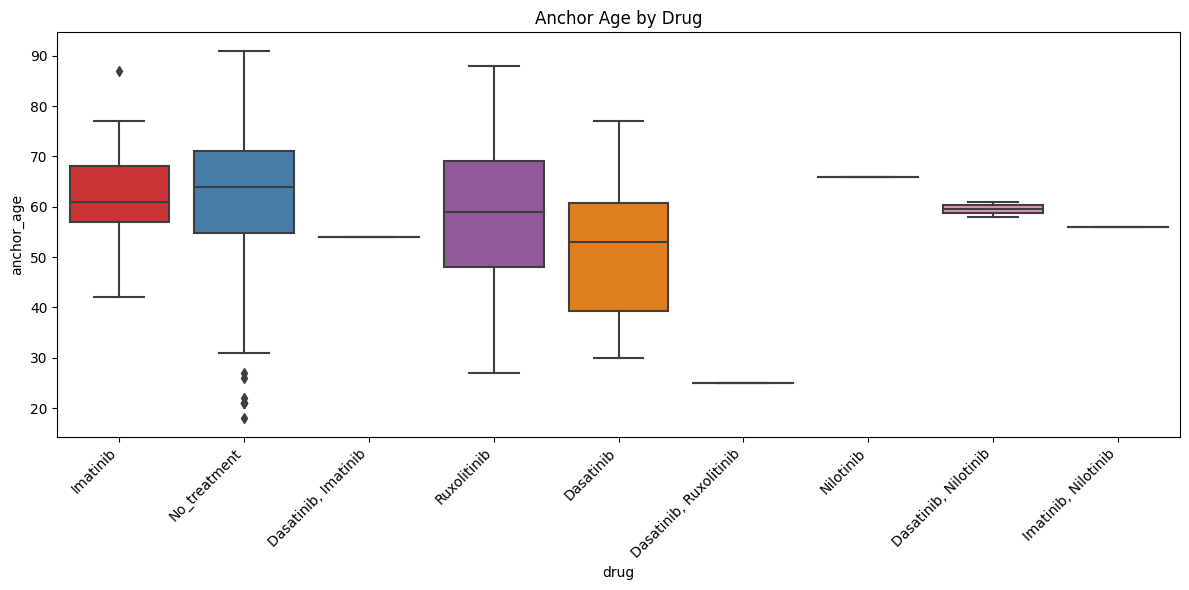

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_drugs_grouped, x='drug', y='anchor_age', palette='Set1')
plt.xticks(rotation=45, ha='right')
plt.title("Anchor Age by Drug")
plt.tight_layout()
plt.show()

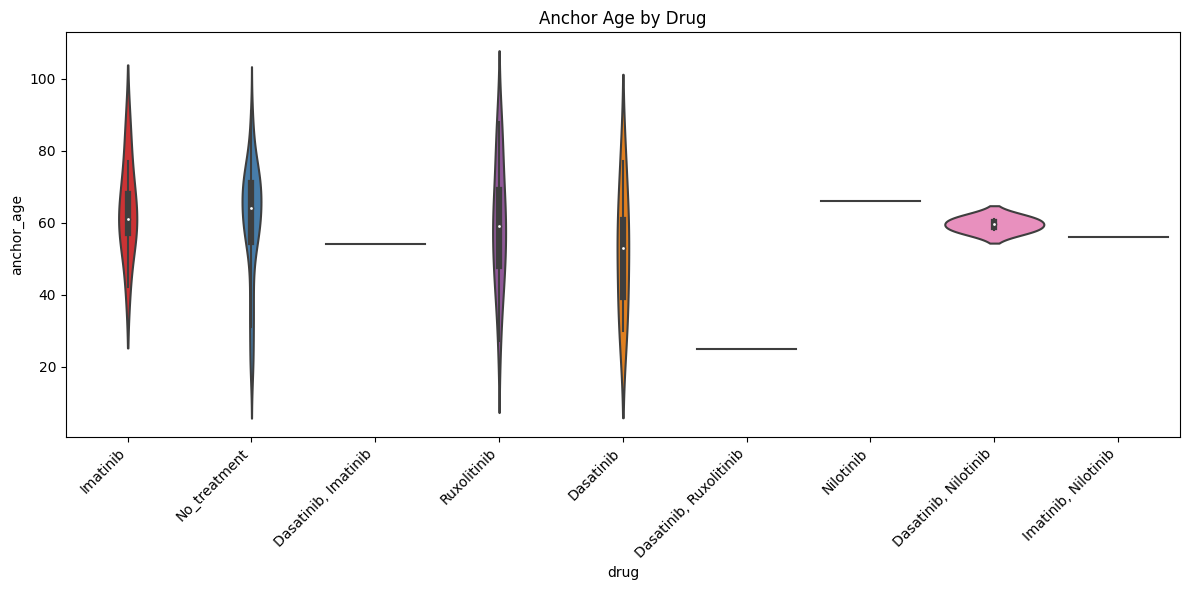

In [32]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_drugs_grouped, x='drug', y='anchor_age', inner='box', palette='Set1')
plt.xticks(rotation=45, ha='right')
plt.title("Anchor Age by Drug")
plt.tight_layout()
plt.show()

In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_triangular_heatmap(data, features, drop_cols=None, filter_no_treatment=True):
    """
    Plots a triangular correlation heatmap using selected features.

    Parameters:
    - data: DataFrame with numeric variables
    - features: list of feature names to include
    - drop_cols: optional list of columns to exclude from correlation matrix
    - filter_no_treatment: if True, exclude rows where data['drug']=='No_treatment' (if 'drug' column exists)
    """
    # Filter out 'No_treatment' if requested and 'drug' column exists
    if filter_no_treatment and 'drug' in data.columns:
        data = data[data['drug'] != 'No_treatment']

    # Select only the features you want
    feature_data = data[features].copy()

    # Drop any columns you want to exclude
    if drop_cols:
        feature_data = feature_data.drop(columns=drop_cols, errors='ignore')

    # Compute the correlation matrix
    corr = feature_data.corr(method='pearson')  # or 'spearman', 'kendall'

    # Create mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the figure
    f, ax = plt.subplots(figsize=(16, 14))

    # Custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap
    sns.set_style("white")
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        annot=False,
        fmt=".2f",
        cbar_kws={"shrink": 0.8}
    )

    plt.title("Correlation Heatmap", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

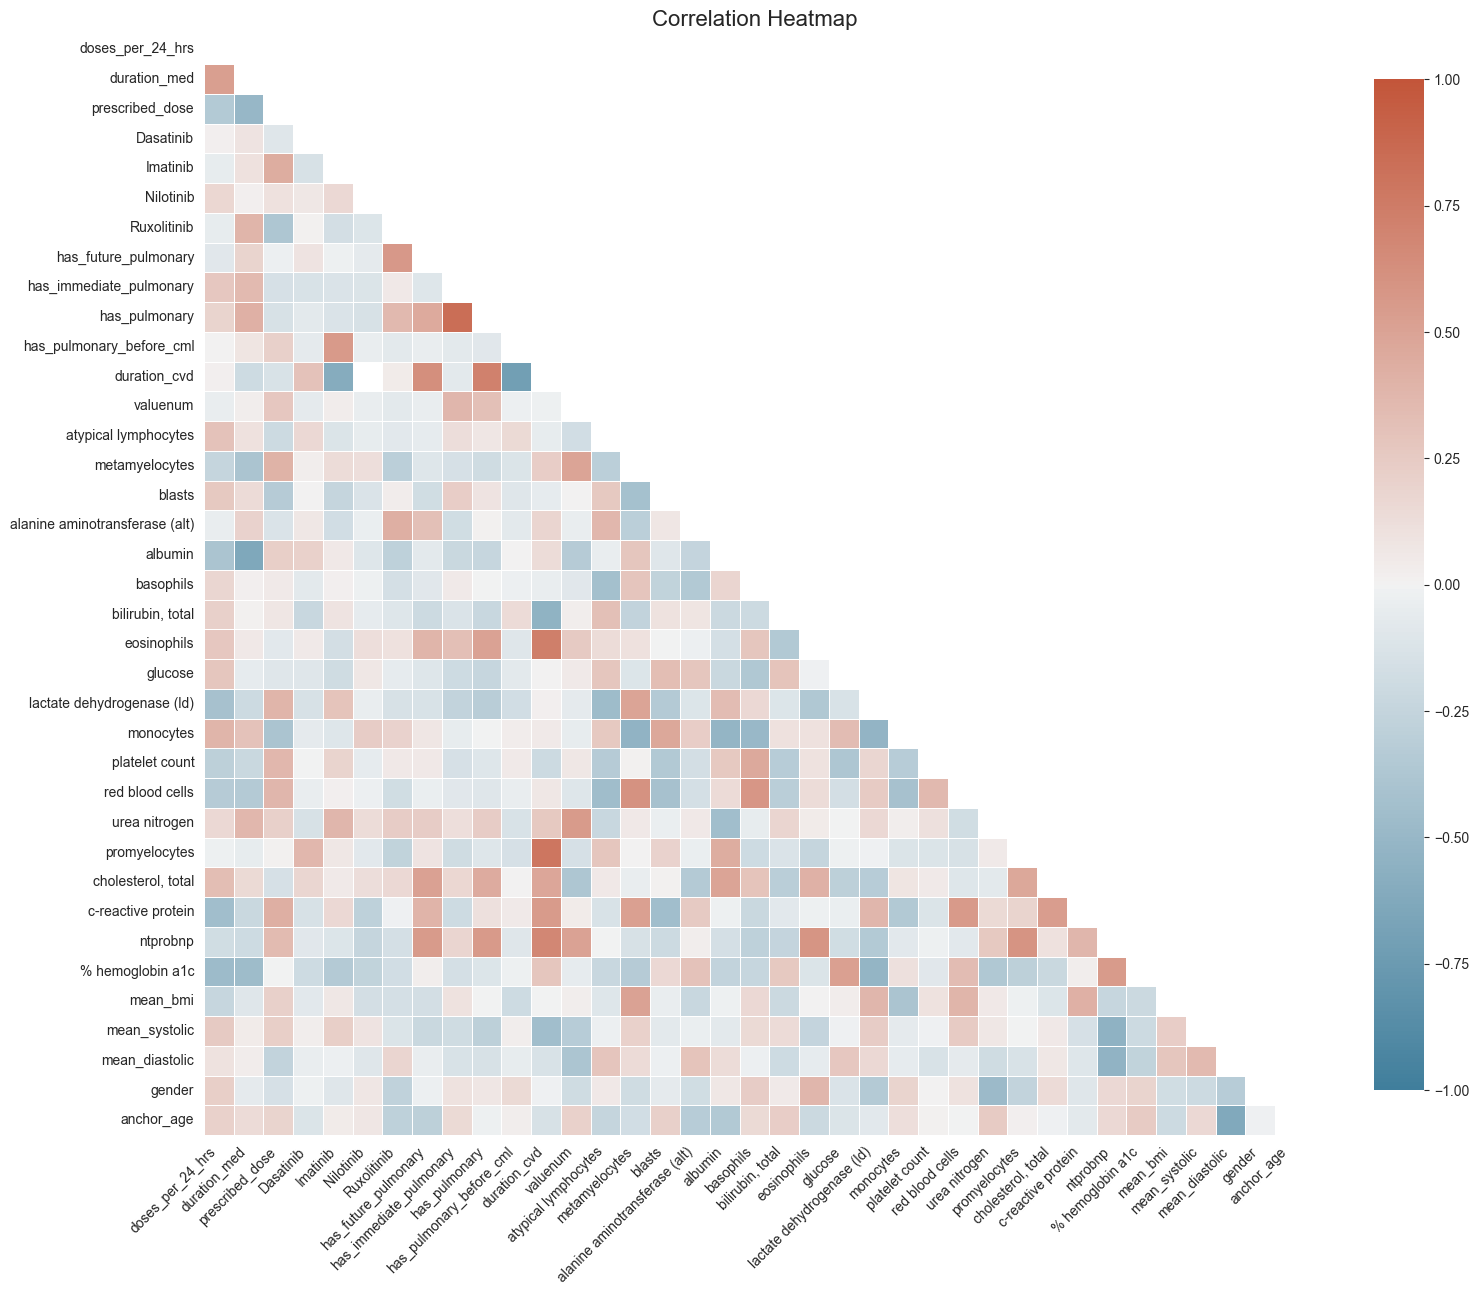

In [37]:
numeric_cols = df_drugs_grouped.select_dtypes(include='number').columns.tolist()
plot_triangular_heatmap(df_drugs_grouped, numeric_cols, drop_cols=['subject_id', 'drug', 'value', 'Cabozantinib', 'Crizotinib', 'pulmonary'])

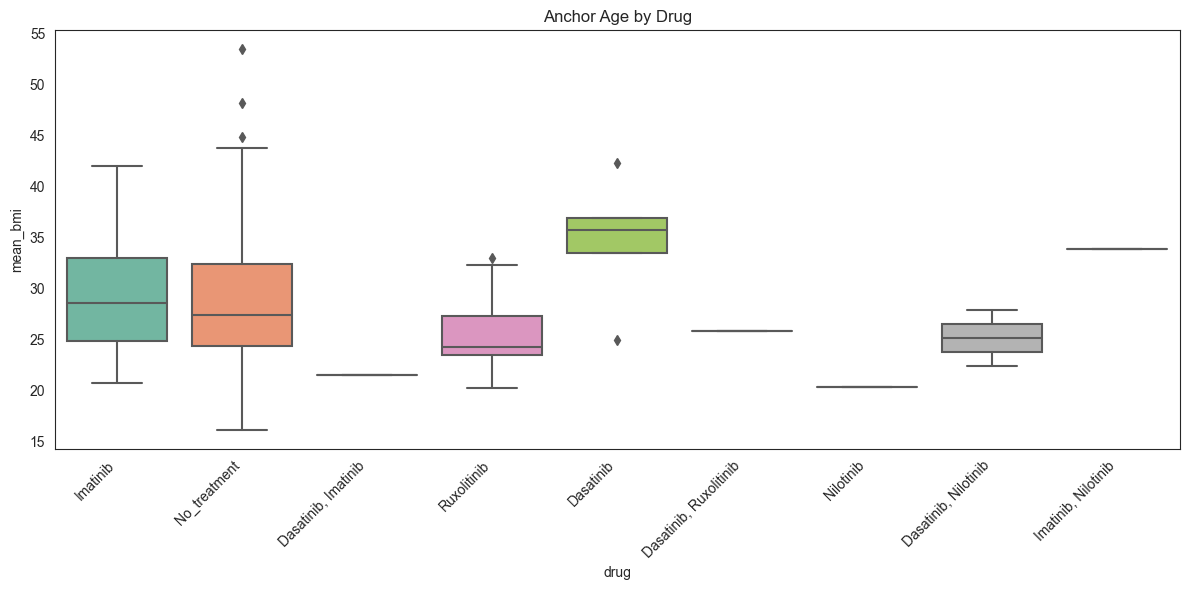

In [40]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_drugs_grouped, x='drug', y='mean_bmi', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title("Anchor Age by Drug")
plt.tight_layout()
plt.show()

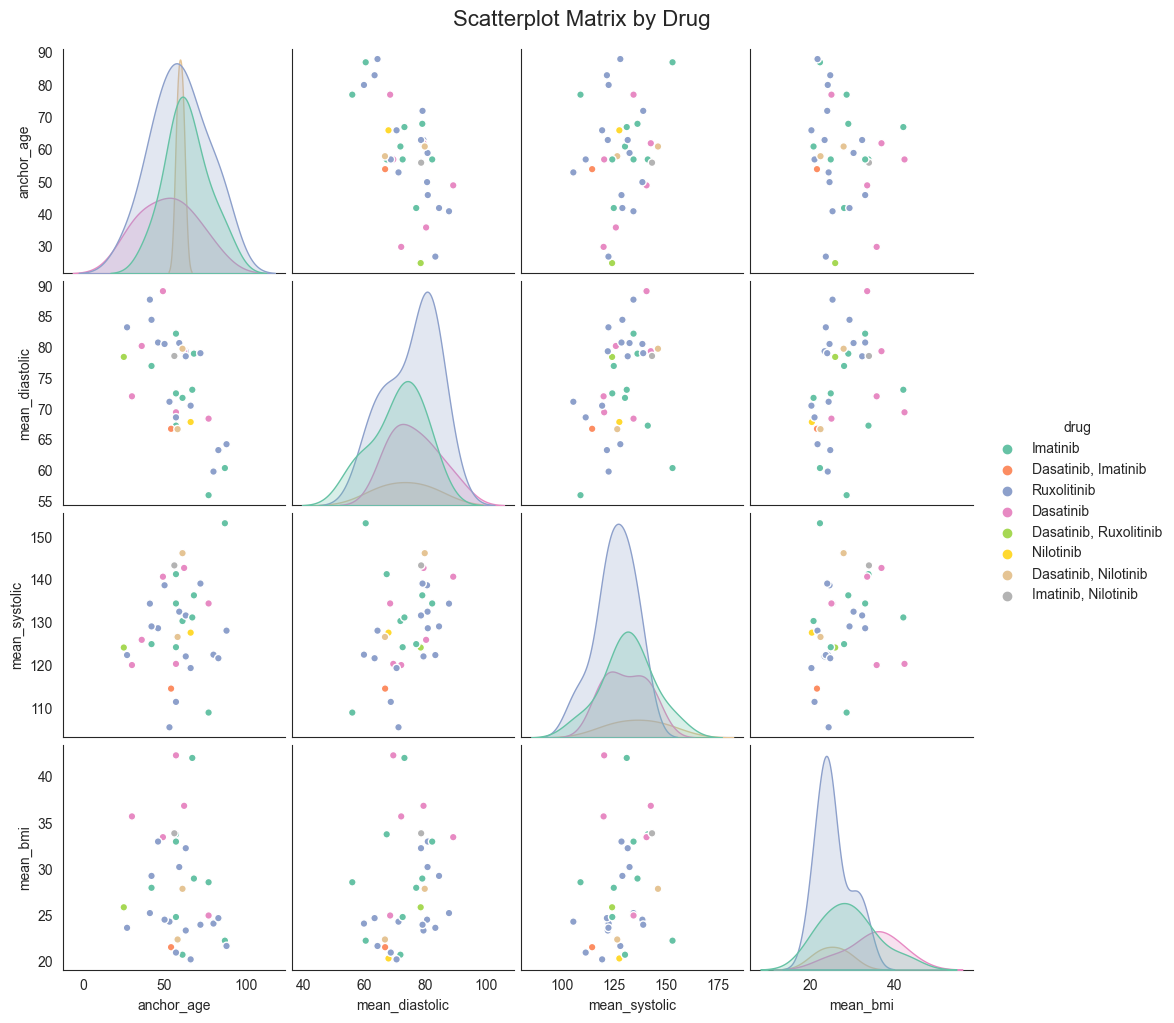

In [50]:
df_drugs_grouped_nt['gender'] = df_drugs_grouped_nt['gender'].map({'M': 0, 'F': 1})

pairplot_vars = ['anchor_age', 'mean_diastolic', 'mean_systolic', 'mean_bmi']

sns.pairplot(
    df_drugs_grouped_nt,
    vars=pairplot_vars,
    hue='drug',
    kind='scatter',
    palette='Set2',
    plot_kws=dict(s=30, linewidth=1)
)
plt.suptitle("Scatterplot Matrix by Drug", y=1.02, fontsize=16)
# plt.tight_layout()
plt.show()

In [95]:
df_drugs_grouped_nt = df_drugs_grouped_nt.drop('drug', axis=1).copy()

In [96]:
df_drugs_grouped_nt.shape

(36, 41)

In [62]:
print(df_drugs_grouped_nt.isna().sum()[df_drugs_grouped_nt.isna().sum() > 0])

pulmonary                         27
duration_cvd                      27
atypical lymphocytes               5
metamyelocytes                     3
blasts                             4
alanine aminotransferase (alt)     1
albumin                            2
basophils                          1
bilirubin, total                   1
eosinophils                        1
lactate dehydrogenase (ld)         1
monocytes                          1
promyelocytes                     10
cholesterol, total                23
c-reactive protein                18
ntprobnp                          22
% hemoglobin a1c                  19
mean_bmi                           1
gender                            36
dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from impyute.imputation.cs import mice
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# === SELECT CVD OUTCOME ===
target_col = 'has_pulmonary'  # You can change to 'has_future_pulmonary', etc.

# === SELECT FEATURES ===
lab_features = [
    'atypical lymphocytes', 'metamyelocytes', 'blasts',
    'alanine aminotransferase (alt)', 'albumin', 'basophils',
    'bilirubin, total', 'eosinophils', 'glucose',
    'lactate dehydrogenase (ld)', 'monocytes', 'platelet count',
    'red blood cells', 'urea nitrogen', 'promyelocytes',
    'cholesterol, total', 'c-reactive protein', 'ntprobnp',
    '% hemoglobin a1c'
]
vital_features = ['mean_bmi', 'mean_systolic', 'mean_diastolic', 'anchor_age']
meta_features = ['gender', 'doses_per_24_hrs', 'duration_med']
drug_features = ['Cabozantinib', 'Crizotinib', 'Dasatinib', 'Imatinib', 'Nilotinib']

# Combine all features
features = lab_features + vital_features + meta_features + drug_features

# === CLEAN DATA ===
df_model = df_drugs_grouped_nt.copy()  # Replace with your actual DataFrame if named differently
df_model = df_model.dropna(subset=[target_col])  # Ensure target has no missing values

# Encode gender
df_model['gender'] = df_model['gender'].map({'M': 0, 'F': 1})

# Filter out rows missing too many key features
df_model = df_model.dropna(subset=features, thresh=int(0.8 * len(features)))  # keep rows with ≥80% features

# Separate X and y
X = df_model[features]
y = df_model[target_col]

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.apply(pd.to_numeric, errors='coerce')

# === IMPUTE MISSING VALUES ===
imputed_array = mice(X.values)
X_imputed = pd.DataFrame(imputed_array, columns=X.columns, index=X.index)

# === DEFINE TRAINING FUNCTION ===
def train_model(X, y):
    pipeline = Pipeline([
        ('scaler', None),
        ('classifier', None)
    ])

    scalers = {
        'RobustScaler': RobustScaler(quantile_range=(10, 90)),
        'PowerTransformer': PowerTransformer(method='yeo-johnson')
    }

    classifiers = {
        'LogReg': LogisticRegression(max_iter=1000),
        'RandomForest': RandomForestClassifier(n_estimators=500),
        'SVM_Linear': SVC(kernel='linear'),
        'SVM_RBF': SVC(kernel='rbf'),
        'XGB': XGBClassifier(n_estimators=300, use_label_encoder=False, eval_metric='logloss')
    }

    scoring = {
        'Accuracy': 'accuracy',
        'Precision': 'precision',
        'Recall': 'recall',
        'AUC': 'roc_auc'
    }

    results = {}
    for scaler_name, scaler in scalers.items():
        for clf_name, clf in classifiers.items():
            pipeline.set_params(scaler=scaler, classifier=clf)
            cv_scores = cross_validate(pipeline, X, y, cv=5, scoring=scoring)
            results[(scaler_name, clf_name)] = cv_scores

    return results

In [52]:
df_drugs_grouped_nt.columns

Index(['subject_id', 'drug', 'doses_per_24_hrs', 'duration_med',
       'prescribed_dose', 'Cabozantinib', 'Crizotinib', 'Dasatinib',
       'Imatinib', 'Nilotinib', 'Ruxolitinib', 'pulmonary',
       'has_future_pulmonary', 'has_immediate_pulmonary', 'has_pulmonary',
       'has_pulmonary_before_cml', 'duration_cvd', 'valuenum',
       'atypical lymphocytes', 'metamyelocytes', 'blasts',
       'alanine aminotransferase (alt)', 'albumin', 'basophils',
       'bilirubin, total', 'eosinophils', 'glucose',
       'lactate dehydrogenase (ld)', 'monocytes', 'platelet count',
       'red blood cells', 'urea nitrogen', 'promyelocytes',
       'cholesterol, total', 'c-reactive protein', 'ntprobnp',
       '% hemoglobin a1c', 'mean_bmi', 'mean_systolic', 'mean_diastolic',
       'gender', 'anchor_age'],
      dtype='object')